starting simulation
55835.63691086273


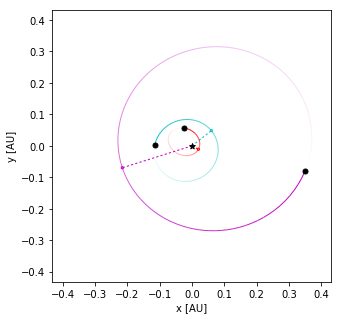

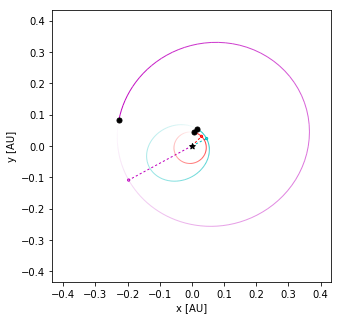

In [14]:
#The purpose of this script is to run the jobs generated by "make_4planet.py". Actual 5-body simulations
import pandas as pd
import numpy as np
import os
import sys
import rebound
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline 

#if a collision occurs, end the simulation
def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0

id_ = int(145)
#165 lasted a long time, 145, 150 didn't

#arguments
system = "KOI-94_r3"
maxorbs = float(1000000000)
Nplanets = int(3)
name = system+"_"+str(int(np.log10(maxorbs)))+"_"+str(id_)

#load data
data = pd.read_csv('systems/%s_data.csv'%system)
d = data.iloc[id_]

Ms=d["Ms"]

#find minimum mutual hill radius (where collisions will be detected)
a=np.zeros(Nplanets)
for i in range(Nplanets):
    a[i]=((d["P%d"%(i+1)]/365*(2*np.pi))**2 * Ms)**(1./3.)
mut_hill=np.zeros(Nplanets-1)
earth = 0.000003003
for i in range(Nplanets-1):
    mut_hill[i]=np.mean([a[i],a[i+1]])*((d["m%d"%(i+1)]+d["m%d"%(i+2)])*earth/Ms/3.)**(1./3.)
minhill=min(mut_hill)

#set up simulation
sim = rebound.Simulation()
sim.getWidget(size=(400,200))
sim.integrator = 'whfast'
sim.G = 1
sim.ri_whfast.safe_mode = 0
sim.collision = 'direct'
sim.collision_resolve = collision

#add star
sim.add(m=Ms)

#add planets
for i in range(1,Nplanets+1):
    m = d["m%d"%i]*earth
    P = d["P%d"%i]
    e = d["e%d"%i]
    w = d["w%d"%i]
    M = d["MA%d"%i]
    sim.add(m=m, P=P*2*np.pi/365., e=e, omega=w, M=M, r=minhill) #G=1 units!
sim.move_to_com()

#timestep
#To ensure a low energy error (dE/E(0) < 1e-9) the timestep needs to be a small fraction of the innermost orbital period (in this case roughly 3%).
#Studies have shown that if the timestep is an exact fraction of the innermost orbital period then numerical artifacts can be introduced 
dt = 2.*math.sqrt(3)/100. #0.0346410162
P1 = sim.particles[1].P
sim.dt = dt*P1 # ~3% orbital period
tmax = maxorbs*P1/10000

#save simulation archive
#dir_path = os.path.dirname(os.path.realpath(__file__)) #directory of this program
#out_dir = dir_path+"/output/"
#os.system('mkdir %s'%out_dir)

#simulate
print("starting simulation")
t0=sim.t
fig1 = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, periastron=True)
sim.integrate(tmax)

fig2 = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, periastron=True)
t=sim.t-t0
#print(t/tmax)
print(t/P1)

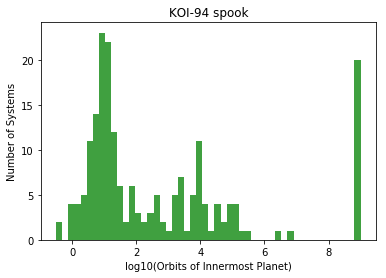

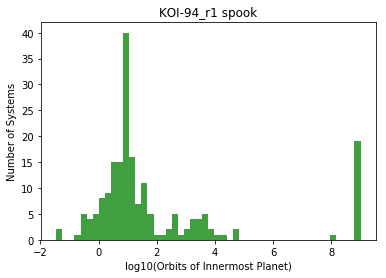

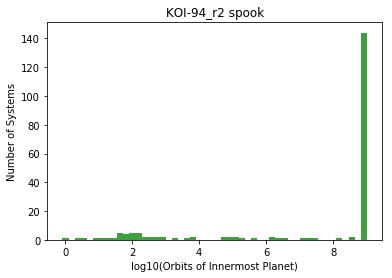

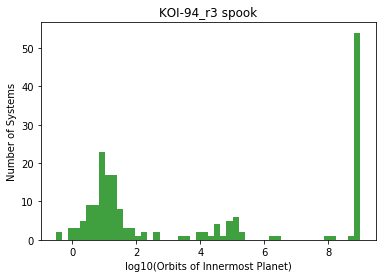

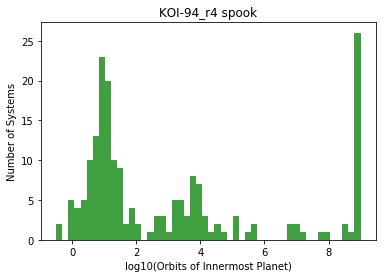

In [17]:
#histogram
stuff=["","_r1","_r2","_r3","_r4"]
for i in range(len(stuff)):
    data=pd.read_csv("systems/KOI-94"+stuff[i]+"_Nbodyresults.csv",header=None)
    use="time"
    
    if use=="orbits":
        times=np.log10(data[4])
        n, bins, patches = plt.hist(times, 50, facecolor='g', alpha=0.75)
        plt.xlabel("log10(Time (yr/2*pi))")
    else:
        orbits=np.log10(np.divide(data[4],data[3]))
        n, bins, patches = plt.hist(orbits, 50, facecolor='g', alpha=0.75)
        plt.xlabel("log10(Orbits of Innermost Planet)")
    plt.ylabel("Number of Systems")
    plt.title("KOI-94"+stuff[i]+" Stability Times")
    plt.show()